In [ ]:
#!/bin/bash
!kaggle datasets download saeedazfar/customized-cotton-disease-dataset


Dataset URL: https://www.kaggle.com/datasets/saeedazfar/customized-cotton-disease-dataset
License(s): unknown
100% 1.92G/1.92G [00:28<00:00, 158MB/s]
100% 1.92G/1.92G [00:28<00:00, 73.4MB/s]


In [ ]:
!unzip /content/customized-cotton-disease-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Customized Cotton Dataset-Complete/content/trainning/Cotton leaves - Training/800 Images/Bacterial blight/random_crop_pil_sharpness_33.jpg  
  inflating: Customized Cotton Dataset-Complete/content/trainning/Cotton leaves - Training/800 Images/Bacterial blight/random_crop_pil_sharpness_34.jpg  
  inflating: Customized Cotton Dataset-Complete/content/trainning/Cotton leaves - Training/800 Images/Bacterial blight/random_crop_pil_sharpness_35.jpg  
  inflating: Customized Cotton Dataset-Complete/content/trainning/Cotton leaves - Training/800 Images/Bacterial blight/random_crop_pil_sharpness_36.jpg  
  inflating: Customized Cotton Dataset-Complete/content/trainning/Cotton leaves - Training/800 Images/Bacterial blight/random_crop_pil_sharpness_37.jpg  
  inflating: Customized Cotton Dataset-Complete/content/trainning/Cotton leaves - Training/800 Images/Bacterial blight/random_crop_pil_sharpness_38.jpg  
  inflating: Customized C

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np



In [ ]:
# Define paths
train_dir = "/content/Cotton-Disease-Training/trainning/Cotton leaves - Training/800 Images"
val_dir = '/content/Cotton-Disease-Validation/validation/Cotton plant disease-Validation/Cotton plant disease-Validation'
test_dir = '/content/Cotton-Disease-Validation/validation/Cotton plant disease-Validation/Cotton plant disease-Validation'


In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)



Found 6628 images belonging to 8 classes.
Found 357 images belonging to 8 classes.
Found 357 images belonging to 8 classes.


In [ ]:
# Class weights for imbalanced datasets
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))



In [ ]:
# Load InceptionV3 model
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers initially

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)



87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


208/208 ━━━━━━━━━━━━━━━━━━━━ 152s 615ms/step - accuracy: 0.6199 - loss: 1.1733 - val_accuracy: 0.8796 - val_loss: 0.4298 - learning_rate: 0.0010
Epoch 2/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 166s 496ms/step - accuracy: 0.8206 - loss: 0.5347 - val_accuracy: 0.9076 - val_loss: 0.3077 - learning_rate: 0.0010
Epoch 3/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 105s 492ms/step - accuracy: 0.8556 - loss: 0.4355 - val_accuracy: 0.8768 - val_loss: 0.3876 - learning_rate: 0.0010
Epoch 4/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 143s 499ms/step - accuracy: 0.8602 - loss: 0.4160 - val_accuracy: 0.9384 - val_loss: 0.2177 - learning_rate: 0.0010
Epoch 5/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 107s 492ms/step - accuracy: 0.8812 - loss: 0.3449 - val_accuracy: 0.9188 - val_loss: 0.2825 - learning_rate: 0.0010
Epoch 6/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 140s 488ms/step - accuracy: 0.8818 - loss: 0.3502 - val_accuracy: 0.9216 - val_loss: 0.2698 - learning_rate: 0.0010
Epoch 7/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 144s 497ms/step - accuracy: 0.8938 

In [ ]:
# Fine-tune the model
base_model.trainable = True  # Unfreeze all layers
for layer in base_model.layers[:-50]:  # Freeze first few layers
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)



In [ ]:
# Fine-tuning
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)



Epoch 1/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 146s 563ms/step - accuracy: 0.8635 - loss: 0.4288 - val_accuracy: 0.9356 - val_loss: 0.2078 - learning_rate: 1.0000e-05
Epoch 2/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 112s 475ms/step - accuracy: 0.9016 - loss: 0.2950 - val_accuracy: 0.9356 - val_loss: 0.2186 - learning_rate: 1.0000e-05
Epoch 3/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 103s 482ms/step - accuracy: 0.9050 - loss: 0.2935 - val_accuracy: 0.9496 - val_loss: 0.1696 - learning_rate: 1.0000e-05
Epoch 4/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 102s 476ms/step - accuracy: 0.9171 - loss: 0.2474 - val_accuracy: 0.9440 - val_loss: 0.1820 - learning_rate: 1.0000e-05
Epoch 5/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 144s 490ms/step - accuracy: 0.9262 - loss: 0.2229 - val_accuracy: 0.9328 - val_loss: 0.2255 - learning_rate: 1.0000e-05


In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")



12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9138 - loss: 0.2437
Test Accuracy: 0.94


In [ ]:
# Classification report
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))



12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 608ms/step
                         precision    recall  f1-score   support

          Aphids edited       0.97      0.85      0.90        39
       Army worm edited       0.97      0.95      0.96        40
Bacterial Blight edited       0.97      0.95      0.96        40
        Cotton Boll rot       1.00      0.84      0.91        61
      Green Cotton Boll       0.87      1.00      0.93        59
    Healthy leaf edited       0.91      1.00      0.95        39
  Powdery Mildew Edited       0.93      1.00      0.96        38
     Target spot edited       0.90      0.93      0.92        41

               accuracy                           0.94       357
              macro avg       0.94      0.94      0.94       357
           weighted avg       0.94      0.94      0.93       357



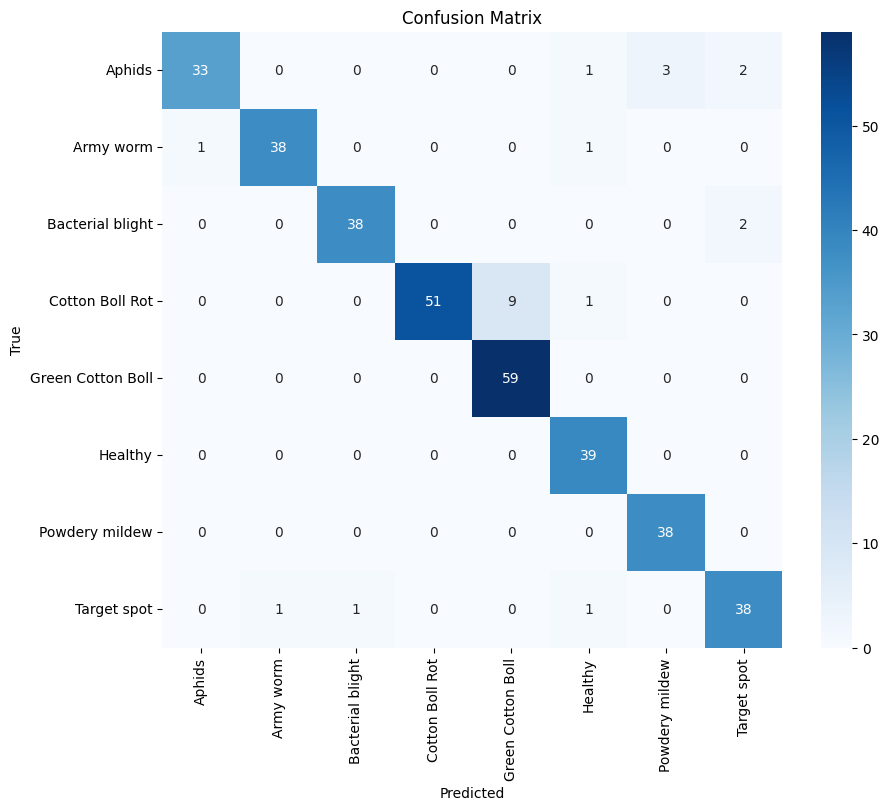

In [ ]:
# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("hello world")


hello world


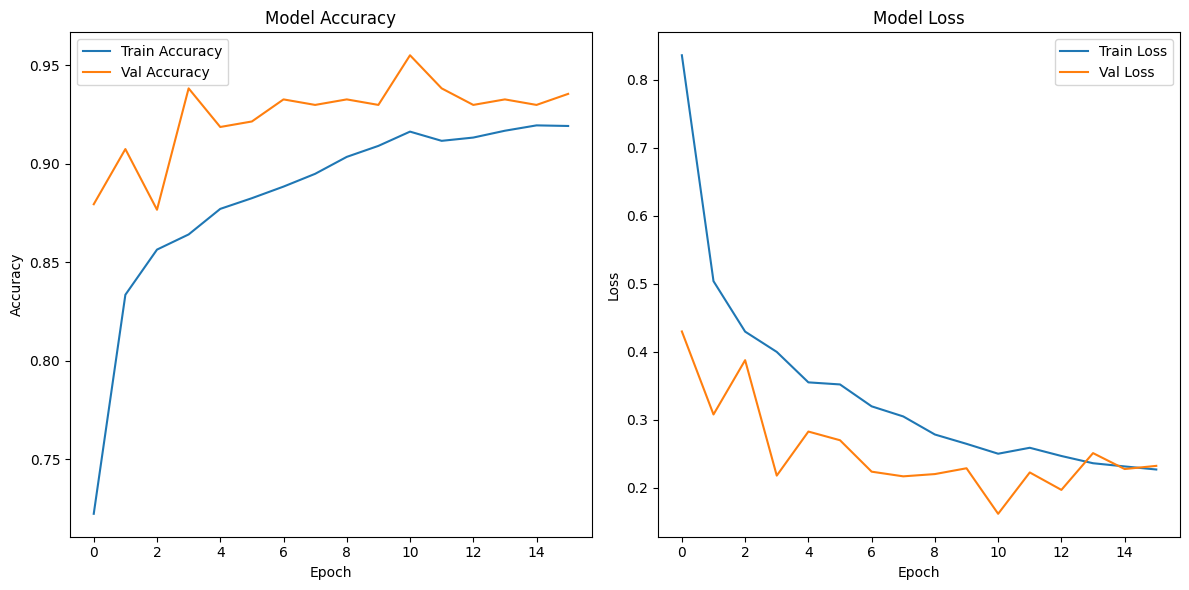

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


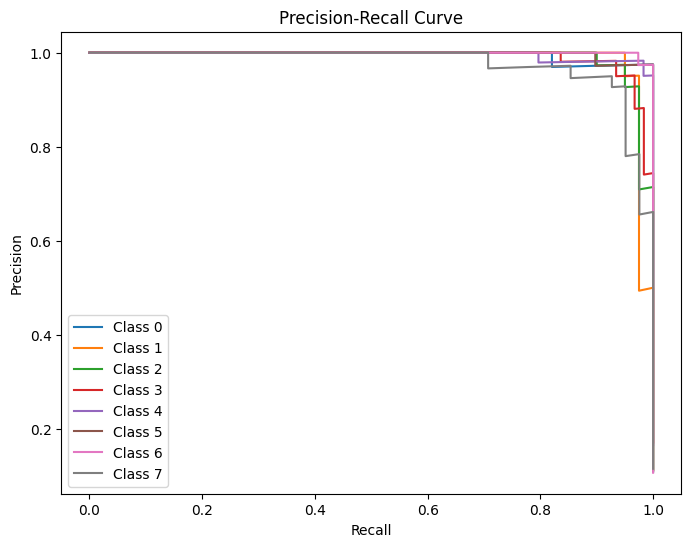

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelBinarizer

y_true_bin = LabelBinarizer().fit_transform(y_true)
y_pred_prob = model.predict(test_generator)

plt.figure(figsize=(8, 6))
for i in range(train_generator.num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="best")
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


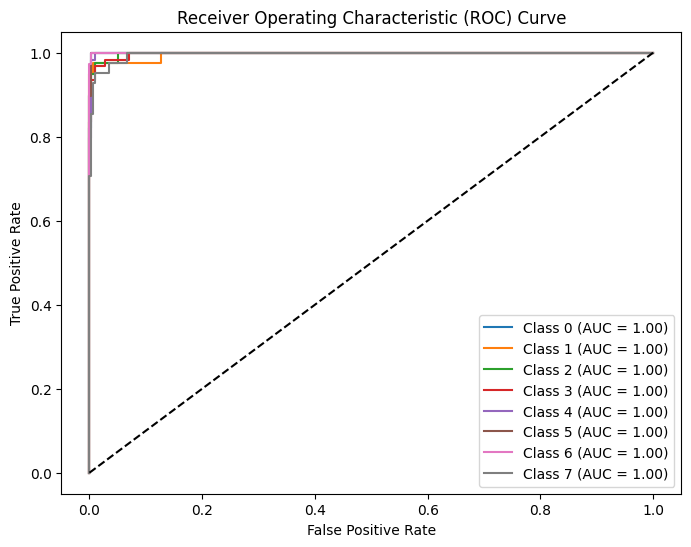

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Binarize the labels for multi-class ROC
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)
y_pred_prob = model.predict(test_generator)

plt.figure(figsize=(8, 6))
for i in range(train_generator.num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="best")
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

print("Precision for each class:", precision)
print("Recall for each class:", recall)
print("F1-Score for each class:", f1)


Precision for each class: [0.97058824 0.97435897 0.97435897 1.         0.86764706 0.90697674
 0.92682927 0.9047619 ]
Recall for each class: [0.84615385 0.95       0.95       0.83606557 1.         1.
 1.         0.92682927]
F1-Score for each class: [0.90410959 0.96202532 0.96202532 0.91071429 0.92913386 0.95121951
 0.96202532 0.91566265]


               Class  Precision    Recall  F1-Score
0             Aphids   0.970588  0.846154  0.904110
1          Army worm   0.974359  0.950000  0.962025
2   Bacterial blight   0.974359  0.950000  0.962025
3    Cotton Boll Rot   1.000000  0.836066  0.910714
4  Green Cotton Boll   0.867647  1.000000  0.929134
5            Healthy   0.906977  1.000000  0.951220
6     Powdery mildew   0.926829  1.000000  0.962025
7        Target spot   0.904762  0.926829  0.915663


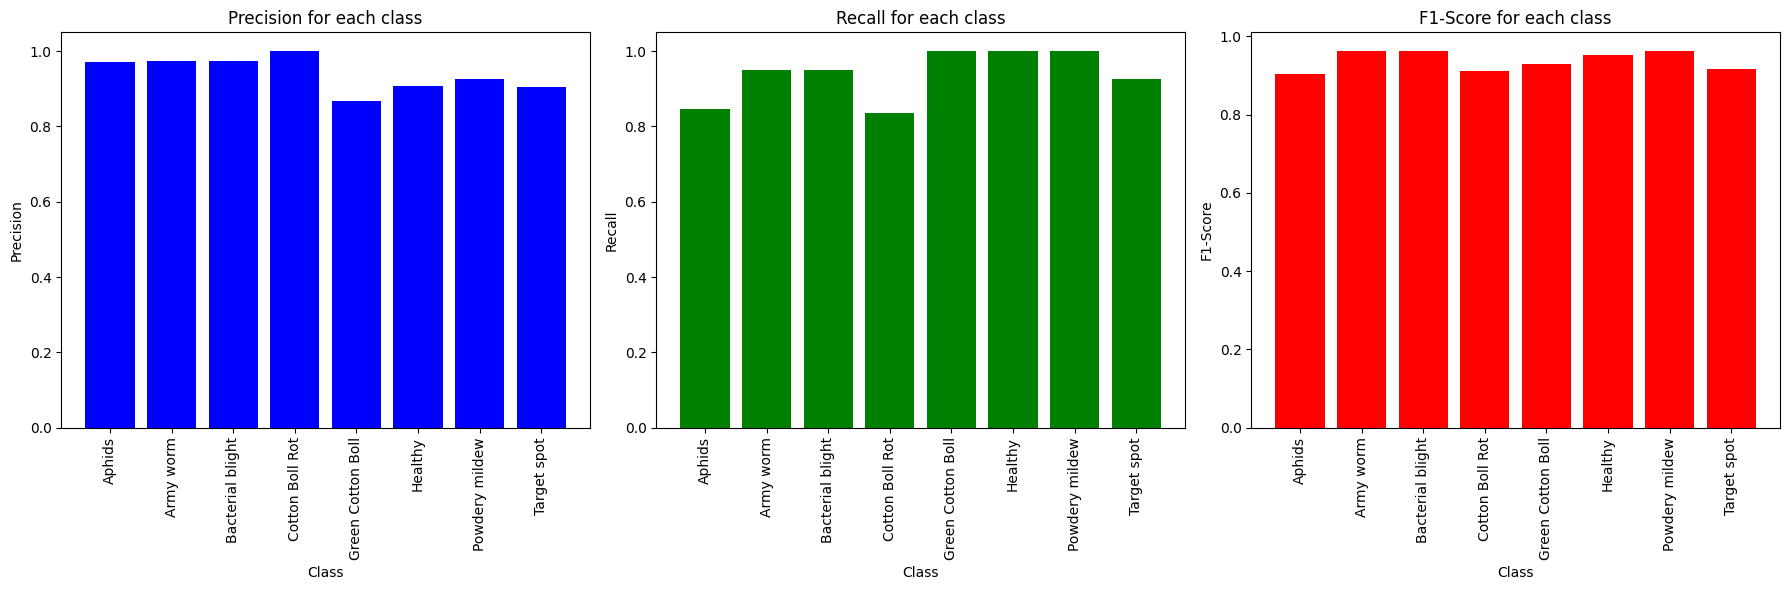

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Precision, recall, and F1-score as calculated
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Get the class names (you can modify if needed based on the actual labels)
class_names = train_generator.class_indices.keys()

# Create a DataFrame to display results in a table
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Display the table
print(metrics_df)

# Plotting the bar charts for Precision, Recall, and F1-Score
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot precision
axes[0].bar(class_names, precision, color='b')
axes[0].set_title('Precision for each class')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Precision')
axes[0].tick_params(axis='x', rotation=90)

# Plot recall
axes[1].bar(class_names, recall, color='g')
axes[1].set_title('Recall for each class')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Recall')
axes[1].tick_params(axis='x', rotation=90)

# Plot F1-Score
axes[2].bar(class_names, f1, color='r')
axes[2].set_title('F1-Score for each class')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('F1-Score')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


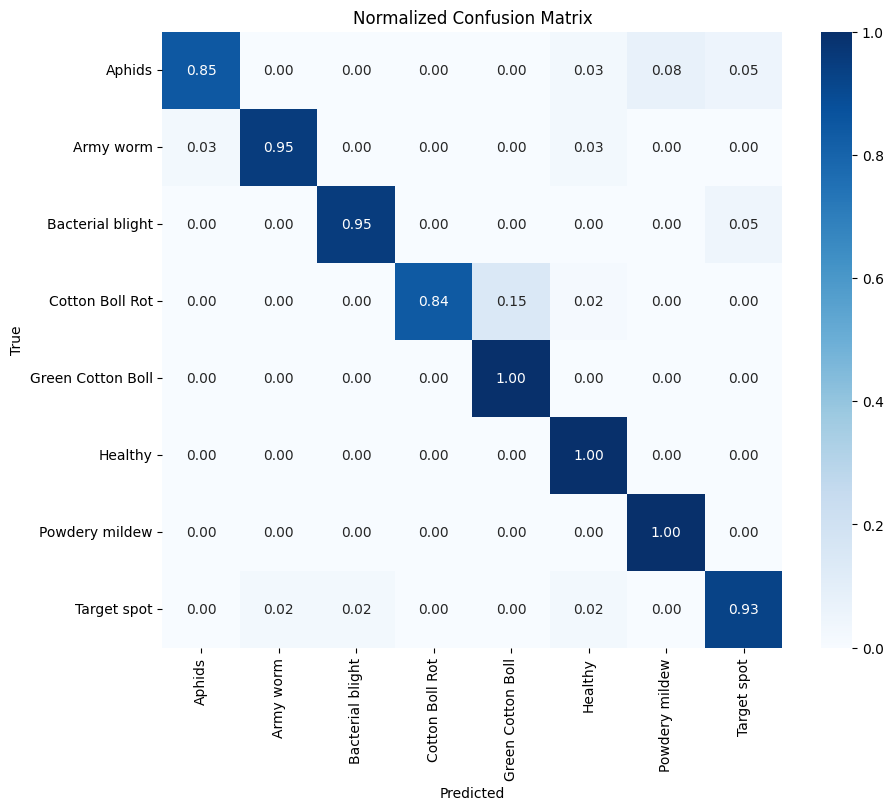

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()


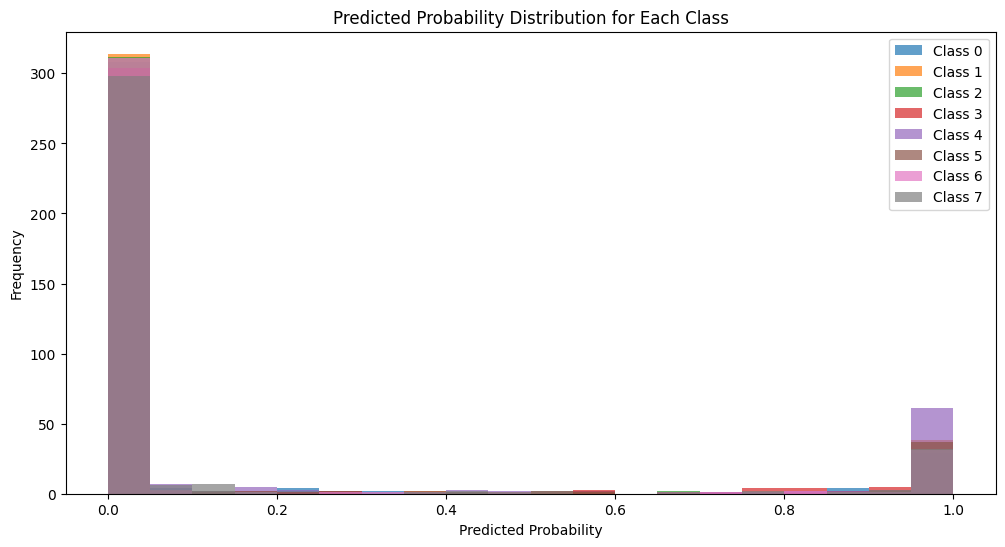

In [ ]:
# Plot histogram of predicted probabilities for each class
plt.figure(figsize=(12, 6))
for i in range(train_generator.num_classes):
    plt.hist(y_pred_prob[:, i], bins=20, alpha=0.7, label=f'Class {i}')

plt.title('Predicted Probability Distribution for Each Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(loc="upper right")
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


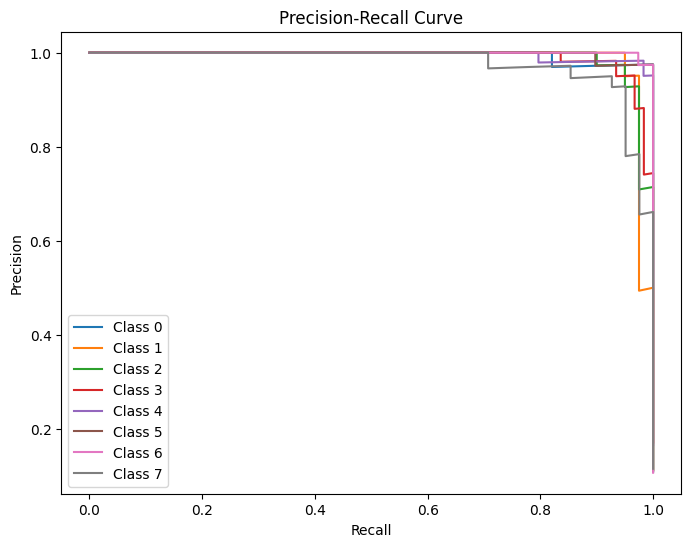

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelBinarizer

y_true_bin = LabelBinarizer().fit_transform(y_true)  # Binarize the true labels
y_pred_prob = model.predict(test_generator)  # Get predicted probabilities

# Plot Precision-Recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(train_generator.num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="best")
plt.show()


In [ ]:
top_k_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
top_k_accuracy.update_state(y_true, y_pred_prob)
print(f"Top-5 Accuracy: {top_k_accuracy.result().numpy():.4f}")


InvalidArgumentError: {{function_node __wrapped__InTopKV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} targets must be 1-dimensional [Op:InTopKV2] name: 